In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from scipy.io import loadmat
import cv2

def load_hoda(training_sample_size=3500, test_sample_size=400, size=28):
    dataset = loadmat('./dataset/Data_hoda_full.mat')
    X_data = dataset['Data']
    y_data = dataset['labels'].astype(np.int32).squeeze()

    X_train_orginal = np.squeeze(X_data[:training_sample_size])
    y_train = y_data[:training_sample_size]
    X_test_original = np.squeeze(X_data[training_sample_size:training_sample_size+test_sample_size])
    y_test = y_data[training_sample_size:training_sample_size+test_sample_size]

    X_train_resized = [cv2.resize(img, dsize=(size, size)) for img in X_train_orginal]
    X_test_resized = [cv2.resize(img, dsize=(size, size)) for img in X_test_original]

    X_train = np.array(X_train_resized, dtype='float32') / 255.0
    X_test = np.array(X_test_resized, dtype='float32') / 255.0
    X_train = X_train.reshape(-1, size, size, 1)
    X_test = X_test.reshape(-1, size, size, 1)

    return X_train, y_train, X_test, y_test

x_train, y_train, x_test, y_test = load_hoda()

# تبدیل لیبل ها به One-hot
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

x_val = x_test[:200]
y_val = y_test[:200]
x_test = x_test[200:]
y_test = y_test[200:]


In [107]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    return model


In [ ]:
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-6, end_lr=1, num_iters=100):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iters = num_iters
        self.lr_mult = (end_lr / start_lr) ** (1/num_iters)
        self.history = {}
        self.iter_count = 0

    def on_train_batch_begin(self, batch, logs=None):
        lr = self.start_lr * (self.lr_mult ** self.iter_count)

        if hasattr(self.model.optimizer, "learning_rate"):
            self.model.optimizer.learning_rate.assign(float(lr))
        elif hasattr(self.model.optimizer, "lr"):
            self.model.optimizer.lr.assign(float(lr))

        self.history.setdefault("lr", []).append(lr)
        self.iter_count += 1

    def on_train_batch_end(self, batch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)


In [ ]:
batch_size = 256
steps = 200 
start_lr = 1e-6
end_lr = 1

model = build_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=float(start_lr)),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

lr_finder = LRFinder(start_lr=start_lr, end_lr=end_lr, num_iters=steps)

history = model.fit(
    x_train, y_train,
    epochs=1,
    batch_size=batch_size,
    steps_per_epoch=steps,
    callbacks=[lr_finder],
    verbose=1
)

print("Collected points:", len(lr_finder.history["lr"]))


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.1026 - loss: 2.3037 
Collected points: 14


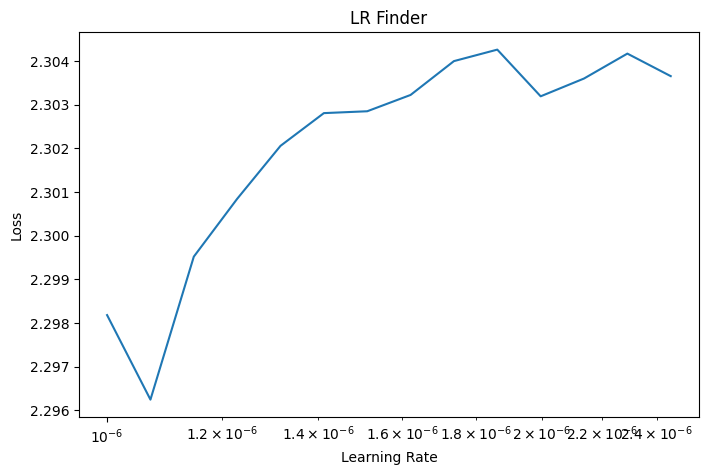

In [110]:
import matplotlib.pyplot as plt

lrs = lr_finder.history["lr"]
losses_list = lr_finder.history["loss"]

plt.figure(figsize=(8,5))
plt.plot(lrs, losses_list)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("LR Finder")
plt.show()


In [111]:
best_lr = 1e-4

model = build_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=best_lr),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=256,
    validation_data=(x_val, y_val),
    verbose=1
)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - categorical_accuracy: 0.1643 - loss: 2.2807 - val_categorical_accuracy: 0.3000 - val_loss: 2.2537
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - categorical_accuracy: 0.2960 - loss: 2.2264 - val_categorical_accuracy: 0.5000 - val_loss: 2.1858
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - categorical_accuracy: 0.3723 - loss: 2.1437 - val_categorical_accuracy: 0.6150 - val_loss: 2.0744
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - categorical_accuracy: 0.4303 - loss: 2.0199 - val_categorical_accuracy: 0.7250 - val_loss: 1.8932
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - categorical_accuracy: 0.4951 - loss: 1.8213 - val_categorical_accuracy: 0.7750 - val_loss: 1.6299
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - categorical_accuracy: 0.5386 - loss: 1.6056 - val_categorical_accuracy: 0.7950 - val_loss: 1.3387
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - categorical_accuracy: 0.5971 - loss: 1.36